# Cost Implications of the Concurrency Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pickle
import os
import re
import json
import seaborn as sns

In [2]:
print("="*80)
print("Cost Implications of the Concurrency Model")
print("-"*80)

Cost Implications of the Concurrency Model
--------------------------------------------------------------------------------


In [3]:
# ensure figures dir exists
os.makedirs('figures', exist_ok=True)

## Read Data

In [4]:
AWS_LOG_DIR = '../dataset/concurrency_models/aws_logs/'
GCP_LOG_DIR = '../dataset/concurrency_models/gcp_logs_varying_rps/'
GCP_LONG_RUN_LOG_DIR = '../dataset/concurrency_models/gcp_logs_rps15/'

In [5]:
aws_data = {}
for filename in os.listdir(AWS_LOG_DIR):
    if "_cloudwatch.json" in filename:
        with open(os.path.join(AWS_LOG_DIR, filename), 'r') as f:
            d = json.load(f)
        rps = int(re.search(r'_(\d+)_cloudwatch', filename).group(1))
        aws_data[rps] = [x for x in d if "Duration:" in x['message']]
for k in aws_data.keys():
    data = aws_data[k]
    for i in range(len(data)):
        data[i] = data[i]['message'].split('Duration: ')[1].split(' ms')[0]
        data[i] = float(data[i])
    aws_data[k] = data

In [6]:
gcp_data = {}
for filename in os.listdir(GCP_LOG_DIR):
    if "_cloud_log.json" in filename:
        with open(os.path.join(GCP_LOG_DIR, filename), 'r') as f:
            d = json.load(f)
        rps = int(re.search(r'_(\d+)_cloud_log', filename).group(1))
        gcp_data[rps] = [x for x in d if 'httpRequest' in x.keys()]
for k in gcp_data.keys():
    data = gcp_data[k]
    for i in range(len(data)):
        data[i] = data[i]['httpRequest']['latency']
        data[i] = float(data[i].split('s')[0]) * 1000
    gcp_data[k] = data

In [7]:
gcp_long_run_data = []
for filename in os.listdir(GCP_LONG_RUN_LOG_DIR):
    if "_cloud_log_part" in filename:
        rps = int(re.search(r'_(\d+)_cloud_log', filename).group(1))
        with open(os.path.join(GCP_LONG_RUN_LOG_DIR, filename), 'r') as f:
            chunk = json.load(f)
        gcp_long_run_data.append(chunk)
gcp_long_run_data = [item for sublist in gcp_long_run_data for item in sublist]

for i in range(len(gcp_long_run_data)):
    gcp_long_run_data[i] = (gcp_long_run_data[i]['timestamp'], gcp_long_run_data[i]['httpRequest']['latency'])
    gcp_long_run_data[i] = (gcp_long_run_data[i][0], float(gcp_long_run_data[i][1].split('s')[0]) * 1000)

def convert_to_epoch(timestamp):
    return int(pd.to_datetime(timestamp).timestamp() * 1000)

for i in range(len(gcp_long_run_data)):
    gcp_long_run_data[i] = (convert_to_epoch(gcp_long_run_data[i][0]), gcp_long_run_data[i][1])
T0 = min([x[0] for x in gcp_long_run_data])
T1 = max([x[0] for x in gcp_long_run_data])
for i in range(len(gcp_long_run_data)):
    gcp_long_run_data[i] = (gcp_long_run_data[i][0] - T0, gcp_long_run_data[i][1])
gcp_long_run_data = sorted(gcp_long_run_data, key=lambda x: x[0])

In [8]:
gcp_long_run_instance_count_data = pd.read_csv(os.path.join(GCP_LONG_RUN_LOG_DIR, 'instance_count.csv'))
gcp_long_run_instance_count_data = gcp_long_run_instance_count_data[gcp_long_run_instance_count_data['TimeSeries ID'].str.contains('GMT')]
def convert_to_epoch_instance_count(timestamp):
    timestamp = timestamp.split('GMT')[0]
    return int(pd.to_datetime(timestamp).timestamp() * 1000)
gcp_long_run_instance_count_data['TimeSeries ID'] = gcp_long_run_instance_count_data['TimeSeries ID'].apply(convert_to_epoch_instance_count)
for i in range(len(gcp_long_run_instance_count_data)):
    gcp_long_run_instance_count_data.iloc[i, 0] = gcp_long_run_instance_count_data.iloc[i, 0] - T0 + 3600 *7 *1000 - 10 * 1000 # timezone offset
gcp_long_run_instance_count_data = gcp_long_run_instance_count_data.sort_values(by='TimeSeries ID')
gcp_long_run_instance_count_data = gcp_long_run_instance_count_data[['TimeSeries ID', 'telemetry-explorer-0-0']]
gcp_long_run_instance_count_data = gcp_long_run_instance_count_data.rename(columns={'telemetry-explorer-0-0': 'active_instance_count'})
gcp_long_run_instance_count_data = gcp_long_run_instance_count_data.rename(columns={'TimeSeries ID': 'timestamp'})
gcp_long_run_instance_count_data['active_instance_count'] = gcp_long_run_instance_count_data['active_instance_count'].astype(int)

Figure saved to figures/concurrency_models.pdf


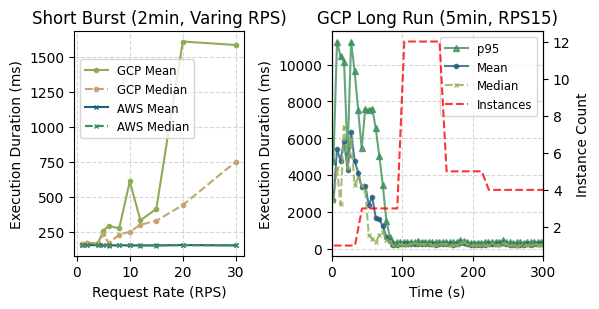

In [9]:
rps_values = sorted(aws_data.keys())
aws_avg = [np.mean(aws_data[k]) for k in rps_values]
aws_median = [np.median(aws_data[k]) for k in rps_values]
gcp_avg = [np.mean(gcp_data[k]) for k in rps_values]
gcp_median = [np.median(gcp_data[k]) for k in rps_values]


timestamps_ms = np.array([t for t, _ in gcp_long_run_data])
durations = np.array([d for _, d in gcp_long_run_data])

timestamps_s = timestamps_ms / 1000.0

bin_width = 5
bins = np.arange(timestamps_s.min(), timestamps_s.max() + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_indices = np.digitize(timestamps_s, bins)

mean_duration = []
p95_duration = []
median_duration = []
for i in range(1, len(bins)):
    mask = bin_indices == i
    if np.any(mask):
        mean_duration.append(durations[mask].mean())
        p95_duration.append(np.percentile(durations[mask], 95))
        median_duration.append(np.median(durations[mask]))
    else:
        mean_duration.append(np.nan)
        p95_duration.append(np.nan)
        median_duration.append(np.nan)
mean_duration = np.array(mean_duration)
p95_duration = np.array(p95_duration)
median_duration = np.array(median_duration)

gcp_long_run_instance_count_data['timestamp_s'] = gcp_long_run_instance_count_data['timestamp'] / 1000.0
mask = (gcp_long_run_instance_count_data['timestamp_s'] >= bin_centers.min()) & \
       (gcp_long_run_instance_count_data['timestamp_s'] <= bin_centers.max())
instance_data_plot = gcp_long_run_instance_count_data[mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.1, 3.2), gridspec_kw={'width_ratios': [0.8, 1.0]})
palette = sns.color_palette("gist_earth", n_colors=4)

ax1.plot(rps_values, gcp_avg,   label='GCP Mean', marker='o', markersize=3, color=palette[2])
ax1.plot(rps_values, gcp_median, label='GCP Median', marker='o', markersize=3, linestyle='--', color=palette[3])
ax1.plot(rps_values, aws_avg,   label='AWS Mean', marker='x', markersize=3, color=palette[0])
ax1.plot(rps_values, aws_median, label='AWS Median', marker='x', markersize=3, linestyle='--', color=palette[1])

ax1.set_xlabel('Request Rate (RPS)')
ax1.set_ylabel('Execution Duration (ms)')
ax1.set_title('Short Burst (2min, Varing RPS)')
ax1.grid(alpha=0.5, linestyle='--')
ax1.legend(fontsize='small', loc='center left', bbox_to_anchor=(0, 0.7))

ax2.plot(bin_centers, p95_duration, label='p95', marker='^', markersize=4, alpha=0.8, color=palette[1])
ax2.plot(bin_centers, mean_duration, label='Mean', marker='o', markersize=3, alpha=0.8, color=palette[0])
ax2.plot(bin_centers, median_duration, label='Median', marker='x', markersize=3, alpha=0.8, linestyle='--', color=palette[2])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Execution Duration (ms)')
ax2.set_xlim(0, 300)
ax2.grid(alpha=0.5, linestyle='--')

ax2b = ax2.twinx()
ax2b.plot(instance_data_plot['timestamp_s'],
          instance_data_plot['active_instance_count'],
          label='Instances', linestyle='--', alpha=0.8, color='red')
ax2b.set_ylabel('Instance Count')

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax2b.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,
           loc='upper right', fontsize='small', ncol=1)

ax2.set_title('GCP Long Run (5min, RPS15)')

plt.tight_layout()
plt.savefig('figures/concurrency_models.pdf', dpi=300)
print("Figure saved to figures/concurrency_models.pdf")
plt.show()

In [10]:
print(f"The average execution time of the function deployed on GCP rises up to {np.max(gcp_avg) / gcp_avg[0]}x")

The average execution time of the function deployed on GCP rises up to 9.64640362217309x


In [11]:
print("GCP (RPS 15) average duration after around 90s: ", np.mean(mean_duration[17:]), "ms")
print("GCP (RPS 1) average duration: ", np.mean(gcp_avg[0]), "ms")
print(f"The average duration is {np.mean(mean_duration[17:]) / gcp_avg[0]} times higher than that under the RPS of 1.")

GCP (RPS 15) average duration after around 90s:  239.2953039187439 ms
GCP (RPS 1) average duration:  166.78331809166667 ms
The average duration is 1.4347676173897892 times higher than that under the RPS of 1.
